#### **This notebook contains the functions used to clean the spectra.**

Import Libraries

In [18]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
from Spectra_Preparation_Functions import *

Read the spectral data

In [19]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")

In [20]:
# df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

In [21]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


#### **Select the chosen cleaning parameters then run the functions**

Choose the Parameters

In [22]:
# # Best Full Spectrum Parameters

lam = 10 ** 7
p = 0.05
window_size = 51
poly_order = 2


# Best 400-1800 Parameters

# lam = 10 ** 8
# p = 0.01
# window_size = 51
# poly_order = 3

# Standard Parameters
# despike_ma = 25
# despike_threshold = 3.75
# lam = 10 ** 5
# p = 0.001
# window_size = 21
# poly_order = 2

# More parameters from optuna
# despike_ma = 19
# despike_threshold = 5.75
# lam = 10**10
# p = 0.049

# Clean Params for Pagerank weights
# despike_ma = 19
# despike_threshold = 5.75
# lam = 10**8
# p = 0.049
# window_size = 11
# poly_order = 2

# pagerank_cutoff = 0.902461
# despike_ma = 57
# despike_threshold = 3.75
# lam = 10 ** 11
# p = 0.074
# window_size = 51
# poly_order = 3

#### **Here is an example on 1 spectrum**

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

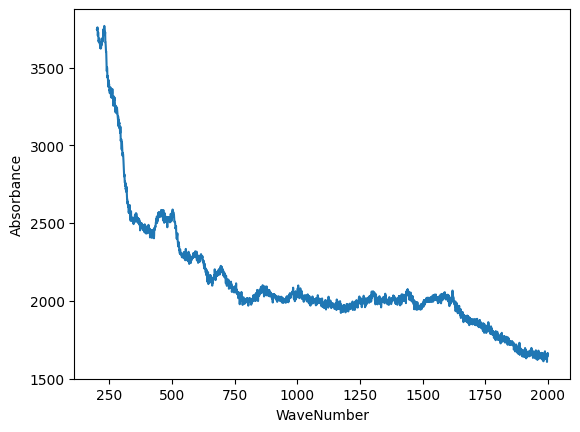

In [23]:
sample = df[df['SpecID'] == "201210-1-07"]
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

/tmp/ipykernel_13336/2465510453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

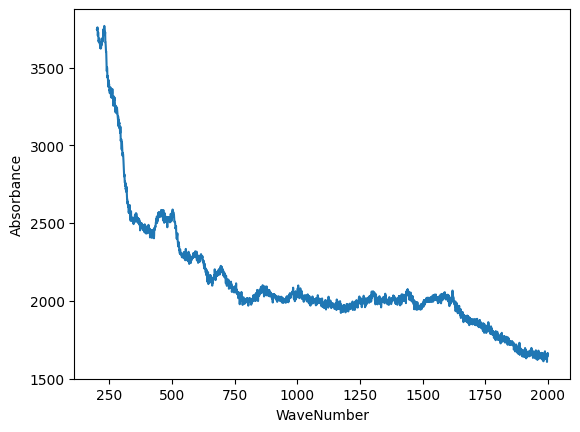

In [24]:
sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

/tmp/ipykernel_13336/3348993900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

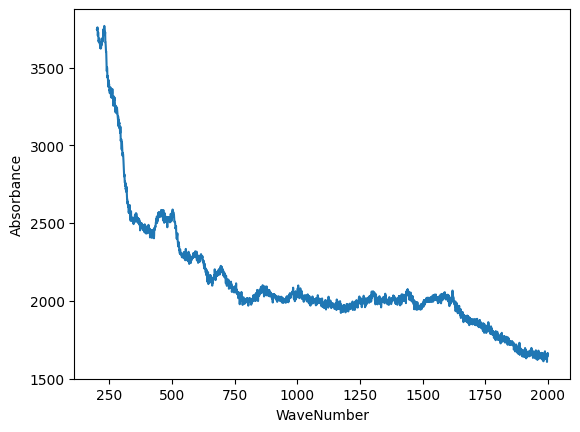

In [25]:
sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

/tmp/ipykernel_13336/742450235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


<Axes: xlabel='WaveNumber', ylabel='Despiked_Absorbance'>

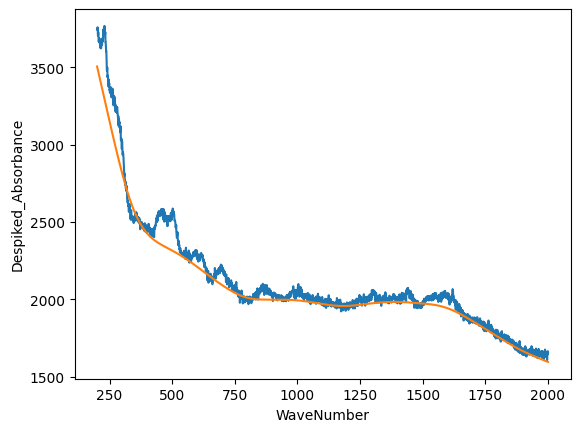

In [26]:
sample['Baseline'] = sample.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Despiked_Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

/tmp/ipykernel_13336/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

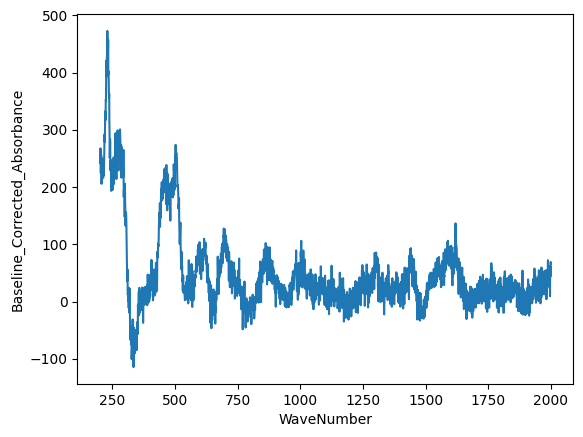

In [27]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Smooth the Baseline_Corrected_Spectrum

/tmp/ipykernel_13336/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

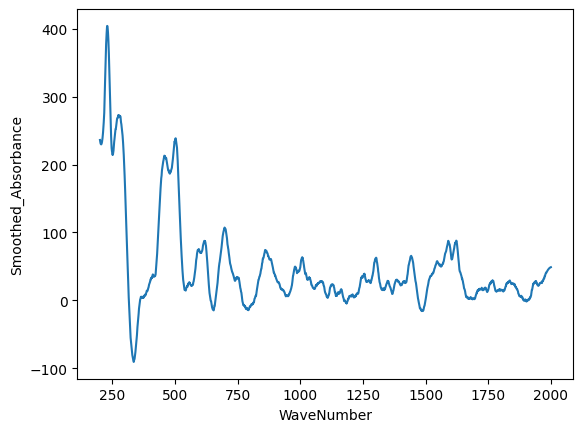

In [28]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

In [29]:
# # Despike

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))

In [30]:
df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))

In [31]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df['Baseline']

In [32]:
df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [33]:
# Optional Scaling
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: normalise(x))
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: vector_normalise(x))
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: svn_normalise(x))

In [34]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Baseline,Baseline_Corrected_Absorbance,Smooth_Baseline_Corrected
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal,2555.806059,153.563841,134.816769
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal,2552.457807,144.673993,132.968425
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal,2549.109556,146.931744,131.193402
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal,2545.761307,132.831193,129.491701
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal,2542.413063,128.479737,127.863322
...,...,...,...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia,1288.540009,32.497091,21.219956
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia,1287.503576,28.902024,21.661414
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia,1286.467144,24.796856,22.127733
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia,1285.430711,32.660189,22.618911


In [35]:
df = df.drop(columns=['Absorbance', 'Baseline', 'Baseline_Corrected_Absorbance'])
df = df.rename(columns={'Smooth_Baseline_Corrected':'Absorbance'})

In [36]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,134.816769
1,201210-1-00,1,200.68336,201210-1,Normal,132.968425
2,201210-1-00,2,201.36674,201210-1,Normal,131.193402
3,201210-1-00,3,202.05011,201210-1,Normal,129.491701
4,201210-1-00,4,202.73349,201210-1,Normal,127.863322
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,21.219956
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,21.661414
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,22.127733
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,22.618911


In [37]:
# df.to_csv("../../data/standard_cleaning.csv", index=False)
df.to_csv("../../data/full_spectrum_cleaning.csv", index=False)
#df.to_csv("../../data/current_clean_spectrum.csv", index=False)
# df.to_csv("../../data/400-1800_spike_removed.csv", index=False)